In [465]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
from enum import Enum
import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
import random as rand
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [466]:
def step(t, dt):
    t = t + dt
    return t

In [467]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            

In [468]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [469]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0 # will need to change this to a beginning value like below
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            try:
                if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
                    # now check vertical edges
                    if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
                        # now check if it has been picked before
                        if sortedFruit[3,j] == 0:
                            # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                            # so it can't really be used either way as a goal
                            key = math.ceil(sortedFruit[1,j]*1000) 
                            # add the value to the b-tree
                            self.fruitBTree.update({key:j})

                elif sortedFruit[1,j] > self.view_max:
                    # no fruit left to add
                    break
                j = j + 1
            except IndexError:
                print("*** Finished going through available fruit ***")
                break
            
        self.i_lastFruit = j
            
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [470]:
class scheduler(object):        
        
    def __init__(self, n_goals, num_row, num_arms, v_max, a_max):
        # need to figure out the type of schedule being used 
                      
        #################### CLASS VARIABLES ####################
        self.v_max = v_max
        self.a_max = a_max
        self.d_max = a_max
        
        # robotic system configuration
        self.num_rows     = num_row
        self.num_arms_row = num_arms
        
        total_arms = self.num_rows * self.num_arms_row
        
        # arm mounting frame width, since arms aren't just points in space
        self.mounting_width = 0.2 # should match the cylinder drawn by the draw class 
        
        # variables for the goals
        self.n_goals = n_goals # number of goals the greedy scheduler will find
        # create a matrix of queues that hold the next fruit to pick, one queue per each arm 
        self.goal_queue = np.ndarray((self.num_rows, self.num_arms_row), dtype=object) # create the matrix
        
        for rows in range(self.num_rows):       
            for count in range(self.num_arms_row): 
                self.goal_queue[rows, count] = queue.Queue() # populate the matrix with queue objects
        
        # cleanup of passed fruit variables
        self.badApples = [] # list of indexes that have been passed over by an arm
        
        ######################### FLAGS #########################
        # until I can figure out Enum
        
        # Arm cofiguration flags
        self.conf_INDIVIDUAL = 0
        self.conf_SHARED     = 1
        
        ######################## MODULES ########################
  
        
        ################ SELF FUNCTIONS AT INIT #################
        self.trajCalc = Trajectory(self.v_max, self.a_max, self.d_max) # to be able to calculate trajectories              
                    
    def greedyScheduler(self, a, row_picture, fruit, v_v, arm_conf):
        # base setting is with arms as individuals
        
        # keyword parameters in functions, https://treyhunner.com/2018/04/keyword-arguments-in-python/
        
        # get arm or for each arm?
        for rows in range(self.num_rows): 
            
            arm_location = np.zeros([self.num_rows, self.num_arms_row])
            back_edge    = np.zeros([self.num_arms_row, 1])
            front_edge   = np.zeros([self.num_arms_row, 1])
            # variable that adds up times to goal to figure out the edges for the next arm 
            time_tot = []
            
            # list of all the goals that will be put into a queue at the end
            pregoals = []
                        
            for i in range (self.num_arms_row):
                # create a matrix with the starting location values for all three arms
                arm_location[i] = np.copy(a[rows,i].q_a)
                # create arrays for the front and back edges of each arm
                back_edge[i]  = np.copy(a[rows,i].y_edges_f[1])
                front_edge[i] = np.copy(a[rows,i].y_edges_f[0])
                # create a new list in time_tot for each new arm
                time_tot.append([0.])
                # make a list of pregoals in the row list, for each arm
                pregoals.append([])
                
            unpick = [] # list to make sure goals don't repeatedly get checked but are unlisted as picked later
            
            # get list of next X number of fruit and add them to a queue
            for pears in range(n_goals):
                for arm_free in range((self.num_arms_row-1), -1, -1): # as long as the arms are moving back to front picking fruits,
#                 for arm_free in range(self.num_arms_row):
                    # we need to figure out the back arm's location first?
                    if len(row_picture[rows].fruitBTree) > 0:                               
                        
                        # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                        potential_key = math.floor(back_edge[arm_free]*1000)
                    
                        # find a value in the B-tree that fits the first location 
                        try: # if no key exists after the potential key, break out rather than crash the program
                            key = row_picture[rows].fruitBTree.minKey(potential_key) 
                            index = row_picture[rows].fruitBTree[key]

                            # check that the goal/fruit does not pass the front part of the frame if frontmost arm
                            # or if the arm's are in individual work space
                            if arm_free == self.num_arms_row-1 or arm_conf == self.conf_INDIVIDUAL:
                                if fruit.sortedFruit[1,index] > front_edge[arm_free]:
                                    # if it does, stahp
                                    break
                            # choose the first fruit as a goal to be given to the arm
                            goal_new = row_picture[rows].fruitBTree.pop(key)
                            goal_coord = np.copy(fruit.sortedFruit[0:3,goal_new])
                            # calculate the time to the fruit
                            p_time = self.pickTime(arm_location[arm_free,:], goal_coord)

                            # compare with back_edge's location at that point, remove if not possible reach (okay if grabbed before vehicle passes)
                            temp_back_edge = back_edge[arm_free] + v_v[1]*p_time # maybe need to add arm speed?

                            if temp_back_edge < goal_coord[1]:  # for now only the y-coordinate
#                                 print("")
#                                 print("arm", arm_free, "in row", rows)
#                                 print("arm location", arm_location[arm_free,1], "goal y-coord",goal_coord[1], "temp back", temp_back_edge)
#                                 print("")

                                # add to list, index is given, not the coordinates
#                                     self.goal_queue[rows, arm_free].put(goal_new)
                                pregoals[arm_free].append(goal_new)
                                # calculate retraction and drop-off times
                                r_time = self.returnTime(arm_location[arm_free,:], goal_coord, a[rows,arm_free].z_edges_f[1])
                                # set newest location
                                arm_location[arm_free,1] = goal_coord[1]          # y-coord goal was last moved y location
                                arm_location[arm_free,2] = a[rows,arm_free].z_edges_f[1] # b/c of drop off, that's the new z-coordinate
                                # x location should always end at the starting point x-coord 

                                if arm_conf == self.conf_INDIVIDUAL:
                                    # if the arms work in individual spaces, they are only affected by the vehicles's speed
                                    back_edge[arm_free] = back_edge[arm_free] + v_v[1]*(p_time + r_time)
                                    front_edge[arm_free] = front_edge[arm_free] + v_v[1]*(p_time + r_time)

                                elif arm_conf == self.conf_SHARED:
                                    # if the arms are sharing the row space, their edges are based on the other arm's velocity
#                                         time_drop[arm_free] = r_time
                                    time_tot[arm_free].append([arm_location[arm_free,1], p_time + r_time])

                                    if arm_free == self.num_arms_row-1:
                                        # don't care about the front edge
                                        front_edge[arm_free] = front_edge[arm_free] + v_v[1]*(p_time + r_time)
                                        # maybe: (prolly will have to calculate it?)
                                        back_edge[arm_free]  = arm_location[arm_free-1,1]+ v_v[1]*(p_time + r_time)

                                    elif arm_free == 0:
                                        # don't care about the back edge
                                        back_edge[arm_free] = back_edge[arm_free] + v_v[1]*(p_time + r_time)
                                        # maybe: (prolly will have to calculate it?)
                                        front_edge[arm_free] = arm_location[arm_free+1,1] + v_v[1]*(p_time + r_time)

                                    else:
                                        # care about both
                                        front_edge[arm_free] = arm_location[arm_free+1,1] + v_v[1]*(p_time + r_time)
                                        back_edge[arm_free]  = arm_location[arm_free-1,1] + v_v[1]*(p_time + r_time)

                                # set the index's fruit as picked
                                fruit.sortedFruit[3,goal_new] = 1
                                fruit.sortedFruit[4,goal_new] = arm_free
                            else:
                                fruit.sortedFruit[3,goal_new] = 1
                                # however, populate a list of fruit that will go back to being not picked after this
                                unpick.append(goal_new)

                        except ValueError:
                            print("*** No value came up, broke out of the if statement ***")
#                             break
                            pass

                # unpick all the unpickable fruit... not doing very much
                for i in range(len(unpick)):
                    fruit.sortedFruit[3,i] = 0
                    print("Clearing some space", i)

            # we can do some post-processing here to make the list of goals better :)

            # add the goals to the queue
            for arms_to_go in range(self.num_arms_row):
                for x in pregoals[arms_to_go]:
                    self.goal_queue[rows, arms_to_go].put(x)
                    
        
    def pickTime(self, a_coord, goal):
        '''Calculate move and extend time for an arm to move from curr position to a fruit position'''
        x_time = self.calcTrapTimes(a_coord[0], goal[0], 0.)
        y_time = self.calcTrapTimes(a_coord[1], goal[1], 0.)
        z_time = self.calcTrapTimes(a_coord[2], goal[2], 0.)
        
        time_pick = x_time + max(y_time, z_time)
        
        return(time_pick)
    
    
    def returnTime(self, a_coord, goal, z_bottom):
        '''Calculate total retract and drop off cycle time for a fruit'''
        # maybe add grip time later?
        
        # calculate x, y and z times as the arm moves from curent position to the goal
        x_time = self.calcTrapTimes(goal[0], a_coord[0], 0.) # opposite :)
        z_time = self.calcTrapTimes(goal[2], z_bottom, 0.)
        
        time_ret = x_time + z_time
        
        return(time_ret)
        
        
    def calcTrapTimes(self, q_start, q_end, v_start):
        '''Get the time it takes to move in trapezoidal trajectory'''
        self.trajCalc.adjInit(q_start, v_start)
        self.trajCalc.noJerkProfile(self.trajCalc.q0, q_end, self.trajCalc.v0, self.v_max, self.a_max, self.d_max)
         
        total_time = self.trajCalc.Ta + self.trajCalc.Tv + self.trajCalc.Td
        
        return(total_time)


    def singleFruitScheduler(self, num_row, num_arms, a, row_picture, fruit):
        '''Assigns fruit one at a time to each fruit. Not really a scheduler, but useful for testing'''
        
        # for each row
        for rows in range(num_row):
            # check if there are any arms that are free 
            for arm_free in range(num_arms):
                if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                    # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                    potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000)
                    # find a value in the B-tree that fits it's location 
                    try: # if no key exists after the potential key, break out rather than crash the program
                        key = row_picture[rows].fruitBTree.minKey(potential_key)
                        index = row_picture[rows].fruitBTree[key]

                        # check that the goal does not pass the front part of the frame
                        if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                            # choose the first fruit as a goal to be given to the arm
                            goal_new = row_picture[rows].fruitBTree.pop(key)
                            # set the index's fruit as picked
                            fruit.sortedFruit[3,goal_new] = 1
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step)                     

                    except ValueError:
                        print("*** No value came up, broke out of the if statement ***")
                        break
                        

In [471]:
class arm(object):        
        
    def __init__(self, q, q_v, n, num_arms, frame_width, frame_height, column_width, row_n, max_vel, max_accel, row_conf):
        
        ## next level would be for them to be seperate threads with access to the global clock -Stavros
        
        ######################### FLAGS #########################
        # until I can figure out Enum
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        self.unloadFlag    = 0     # checks if the arm's moving to the conveyor
        
        # Arm cofiguration flag values
        self.conf_INDIVIDUAL = 0
        self.conf_SHARED     = 1
        
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        self.state         = 0                           # arm's state to log % time used for each activity
        self.row_conf      = row_conf                    # sets if the row space is shared or not
        self.num_arms      = num_arms                    # total number of arms in a row
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        # list of time it took to finish eeach picking cycle
        self.pick_cycle    = []
        self.pick_cycle_s  = 0.  # when the picking cycle timer started
        
        # which fruits were picked and at what time, might only need times if it's being used to determine 
        # the arm's throughput
        self.time_of_picking = []
        
        # frame size
        self.length_f      = 2.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m -> when shared this includes the shared space
        self.height_f      = frame_height # size of enclosing frame, height in m
        self.width_c       = column_width # width of the columns supporting the arms
        
        if self.row_conf == self.conf_SHARED:
            self.width_f    *= self.num_arms # if it's shared space the width is much larger
        
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q_v[1],q[2]])  # frame's center at row and vehicle's center
        
        if self.row_conf == self.conf_INDIVIDUAL:
            self.q_f[1]    = q[1]  # frame's center moves to be individual, rather than the vehicle's center
        
        
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.]) # 0 is the starting position, 1 is max extension
        self.y_edges_f     = np.array([0.,0.]) # 0 is forward, 1 is in the back
        self.z_edges_f     = np.array([0.,0.]) # 0 is the top, 1 is the bottom
        
        if self.row_conf == self.conf_SHARED:
            self.y_edge_end = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel 
        self.a_max         = max_accel  
        self.d_max         = max_accel 
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        self.goals_given   = 0     # how many goals were given to the arm (to check against how many it reached)

        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        self.tz            = 0.      # time used for unloading the fruit on conveyor (only z-dir)        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)   
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        

    ######################## FUNCTIONS ########################
    def armStep(self, v_v, a, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])
        
        epsilon     = 0.001           # allowable error when reaching fruit

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        if self.unloadFlag == 2: # if the arm is unloading, the times are different for z
            goal_time_z = t - self.t_unload
        else:
            goal_time_z = goal_time 
    
        # move along with the vehicle
        self.moveFrame(v_v, a, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time_z)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted or fruit unloaded
            # makes sure that these actions can still happen even if the arm's frame has moved beyond the fruit
            self.v_a[1] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
                self.calcXVel(goal_time_x, v_v)
                    
            elif self.unloadFlag != 0: # and q_curr[0] == self.q_f[0]:
                # move down to the conveyor to drop off the fruit
                self.calcZVel(goal_time_z)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        
        # fix any edge constraints of the arms trying to go past their frame/other arms
        self.edgeConstraintCheck()
                    
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         if self.n == 0 and self.row_n == 0:
#             print("")
#             print("Row:", self.row_n, "Arm:", self.n)
#             print("Edges, X:", self.x_edges_f, "Y:", self.y_edges_f, "Z:", self.z_edges_f)
#             print("Goal: {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("Current location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#             print("")
#             print("Is it free?", self.free)
#             print("Goals reached:", self.goal_r)
#             print("retracting:", self.retractFlag)
#             print("unloading", self.unloadFlag)
#             print("can it reach?", can_reach)
#             print("")
 
        # check if the goal was reached within +/- some error ((corrected and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) and self.unloadFlag != 1:
            # I'm not sure I like using the unload flag as the way to limit the number of times it gets into this if 
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # The number of reached goals is getting over-counted
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
                # set unloading flag to one so that once retraction finishes, unloading can begin
                self.unloadFlag = 1
                # save the time at which it was picked
                self.time_of_picking.append(float(t))
                fruit.sortedFruit[3,self.goal_index] = 2 # set as really picked
                
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # start process of retracting the arm if it has extended at all and if the process has not been started before
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0. 
            
            # start the unloadng process if the retraction has finished
            elif self.unloadFlag == 2 and goal_time_z == goal_time: # will only happen once with the AND
                # if retraction is done, but fruit has not been dropped off
                self.unload()
                # restart the timers
                self.t_unload    = t      # start time for the new timer for unloading
                goal_time_z      = 0.
            
            # end the process of going for the goal 
            elif self.retractFlag == 0 and self.unloadFlag != 2:
                # set the arm as free only if there is no need to retract or drop of fthe fruit or fruit cannot be reached
                self.tx         = 0.
                self.x_move     = 0
                # look at time at which picking cycle ended
                if self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1 and self.free == 0:
                    pick_cycle_e = t - self.pick_cycle_s
                    self.pick_cycle.append(pick_cycle_e)
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0]  = 0
                self.goal_r[1]  = 0
                self.goal_r[2]  = 0
                self.free       = 1 
                # reset the unloading flag 
                self.unloadFlag = 0
                # set state back to idle 
                self.state = 0
                        
        return self.q_a
    
    
    def edgeConstraintCheck(self):
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]: # totally retracted position
            self.q_a[0] = self.q_f[0]
        
        # stop the arm from moving below or above the bottom of the frame (saw it happen)
        if self.q_a[2] < self.z_edges_f[1]: # bottom
            self.q_a[2] = self.z_edges_f[1]
            
        elif self.q_a[2] > self.z_edges_f[0]: # top
            self.q_a[2] = self.z_edges_f[0]
            
        # stop the arm from moving front or back beyond it's y-edges 
        if self.q_a[1] < self.y_edges_f[1]: # back
            self.q_a[1] = self.y_edges_f[1]

        elif self.q_a[1] > self.y_edges_f[0]: # front
            self.q_a[1] = self.y_edges_f[0]
            
    
    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        self.retractFlag = 1
        self.state = 2
        
    
    def unload(self):
        # calculates the trajectory for the arm from curr position to bottom 
        # of the frame (conveyor location) and sets the flag as run the unload sequence
        # should only run if fruit has been obtained and the arm has retracted
        self.z.adjInit(self.q_a[2], self.v_a[2])
        self.z.noJerkProfile(self.q_a[2], self.z_edges_f[1], self.z.v0, self.v_max, self.a_max, self.d_max)
        # set state to unloading
        self.state = 3
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0.) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0.) 
        self.z.adjInit(self.q_a[2], 0.)
        # calculate the trapezoidal times for each of the three movement stages (change to S-curve later)
        self.trapTimes()
        # maybe start time here? => evaluate how that could change things once in real time
        self.t = t
        # start picking cycle time measurement here
        self.pick_cycle_s = t
        # set state as picking 
        self.state = 1
        # increase goals given counter
        self.goals_given += 1
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
        
        # y-dir edges change according to the row space configuration
        if self.row_conf == self.conf_INDIVIDUAL: # the y-dir edge make up individual rectangles
            # front
            self.y_edges_f[0] = self.q_f[1] + self.width_f / 2 - self.width_c/2
            # back
            self.y_edges_f[1] = self.q_f[1] - self.width_f / 2 - self.width_c/2
            
        if self.row_conf == self.conf_SHARED:
            # the y-dir edge are initialized as the whole row minus some space for the other arms
            # front
            self.y_edges_f[0] = self.q_f[1] + self.width_f / 2 - (self.num_arms - self.n+1)*self.width_c
            # back
            self.y_edges_f[1] = self.q_f[1] - self.width_f / 2 - self.n*self.width_c
            
            self.y_edge_end = np.copy(self.y_edges_f)
    

    
    def moveFrame(self, v_v, a, dt):
        
        # x-values are not affected by the other arms (yet?)
        x_coor       = self.q_f[0]           # center of the x-direction in the frame
        self.q_f[0]  = x_coor + v_v[0]*dt # move the center point as the vehicle moves
        
        retract_edge = self.x_edges_f[0]
        extend_edge  = self.x_edges_f[1]
        
        # move x-dir the edges
        self.x_edges_f[0] = retract_edge + v_v[0]*dt
        self.x_edges_f[1] = extend_edge + v_v[0]*dt
        
        
        # calculate the changes in y
        if self.row_conf == self.conf_INDIVIDUAL:
            
            y_coor      = self.q_f[1]        # center of the y-direction in the frame
            self.q_f[1] = y_coor + v_v[1]*dt # move the center point as the vehicle moves
            
            # set the value for the edges
            front_edge  = self.y_edges_f[0]
            back_edge   = self.y_edges_f[1]
            
        elif self.row_conf == self.conf_SHARED: 
            # set the value for the edges
            # got a truncated version of *a* that only has the other arms in that row
            
            self.y_edge_end += v_v[1]*dt # move the ends with the vehicle
            
            if self.n == 0:
                # backmost arm doesn't deal with arms behind it
                back_edge   = self.y_edges_f[1]
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
            
            elif self.n == self.num_arms-1:
                # frontmost arm doesn't deal with arms in front of it
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = self.y_edges_f[0]
                
            else:
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
                
            
            # check that it never goes into space at the edges that would be taken up by the other arms
            if front_edge > self.y_edge_end[0]: 
                front_edge = self.y_edge_end[0]
                
            if back_edge < self.y_edge_end[1]:
                back_edge = self.y_edge_end[1]
                
        # move the edges knowing the vehicle and other arms' velocities, the last bit calculate ahead of time
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt

    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong ==> looking at Zhenghao's work, he assumes constant. However, this is better
        # at the scheduling level
        # ==> becomes just a check for when assuming constant vehicle velocity doesn't work :)        

        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

        else:
            if self.goal[0] != 1 or self.goal[1] != 1 or self.goal[2] != 1:
                # if it's retracting before it reached it's goal, then the fruit was not picked
                fruit.sortedFruit[3,self.goal_index] = 0
                print("Fruit skipped")
                    
            return 0 

            
            
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            # if the unloadflag was primed by reaching the goal, move the flag to "unload state on"
            if self.unloadFlag == 1:
                self.unloadFlag = 2
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
            # set unload flag as done if it was triggered to move at the end of retract 
            if self.unloadFlag == 2:
                self.unloadFlag = 0
        
        
    def pickData(self):
#         x_fr = np.array(self.x)
#         y_fr = np.array(self.y)
#         z_fr = np.array(self.z)
        time_pick = np.array(self.time_of_picking)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
#         inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return time_pick  # until I know that the coordinates are needed, just use this
    

In [472]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))
        arm     = np.full(len(self.x_fruit), np.inf) # will indicate which arm is set to this goal 

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [473]:
class fruitTreeCreator(object):
    # Class that can create synhetic distributions to populate a matrix for the simulator
    def __init__(self, numFruit_row):
        #################### CLASS VARIABLES ####################
        # fruit coordinate lists
        self.x_fr = []
        self.y_fr = []
        self.z_fr = []
        
        # limits for where the fruit can be added
        self.x_lim = [7.,  8.5]
        self.y_lim = [4.5, 20.]
        self.z_lim = [0.,  9.]
        
        # number of fruit created per row, based on input
        self.numFruit = numFruit_row * 3
        
        # initialize the matrix that will give the fruit information
        self.sortedFruit = np.stack([np.zeros(self.numFruit), np.zeros(self.numFruit), np.zeros(self.numFruit), np.zeros(self.numFruit)])
        
        ###################### ENUMERATIONS ######################
#         class Distribution(Enum):
#             UNIFORM = 0,
#             LINE    = 1,
#             CSV     = 2  # Maybe will be a seperate class?
        
    def fruitLine(self, z):
        # function which creates a line of synthetic fruit to test scheduling algorithms
        # z is the height at which all the fruit will be set (since it's a line!)
        
        for fruit in range(self.numFruit):
            # random x-coord for fruit, based on uniform distribution
            self.x_fr.append(rand.uniform(self.x_lim[0], self.x_lim[1]))
            # random y-coord for fruit, based on uniform distribution
            self.y_fr.append(rand.uniform(self.y_lim[0], self.y_lim[1]))
            # z-coordinate (based on z-coordinates given for each line for each row)
            if fruit % 3 == 0:
                self.z_fr.append(z[0])
                
            elif fruit % 3 == 1:
                self.z_fr.append(z[1])
                
            elif fruit % 3 == 2:
                self.z_fr.append(z[2])
                
        self.fruitTreeOut()

    
    def fruitTreeOut(self):
        # converts list of fruit into arrays to build a matrix used in simulator 
        picked  = np.zeros(len(self.x_fr))
        arm     = np.full(len(self.x_fr), np.inf) # will indicate which arm is set to this goal

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([self.x_fr, self.y_fr, self.z_fr, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

In [474]:
## Set Flag values
class spaceConf(Enum):
    '''Flag values for if the workspace in each row is individual or shared'''
    INDIVIDUAL = 0
    SHARED     = 1
    
    
class calendar(Enum):
    '''Flag values for the type of scheduler to use, name seems like a bad idea :P'''
    SINGLE_FRUIT = 0
    GREEDY       = 1
    

class treeCreation(Enum):
    '''Flags values for the type of data being used as fruit coordinates'''
    CSV_RAJ  = 0
    SYN_LINE = 1
    

class noiseMaker(Enum):
    '''Flags values for the type of noise'''
    TURN_OFF = 0
    TURN_ON  = 1

In [479]:
###### Parameter settings, will later become a configuration file ######

# decide if the arms are in individual or shared spaces
space_config = spaceConf.SHARED

# decide on the number of arms and rows
num_arms     = 3           # set number of arms on robot, will determine the length of the robot (for now)
num_row      = 3           # set the number of rows of arms
frame_height = 3.          # set the height of the arm's frame

# arm's max velocity and acceleration values
max_v = 1.
max_a = 10.

# decide on the vehicle starting location and velocity setting
q_v = np.array([6.3,7.])   # starting location
v_v = np.array([0.,0.03])  # in m, constant velocity   => for single fruit got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)

# decide on the type of scheduler
appointment = calendar.GREEDY

# decide what fruit distribution to use to create fruit coordinates
data_config  = treeCreation.SYN_LINE

if data_config != treeCreation.CSV_RAJ: 
    # need a specific number of fruit per row for synthetic data
    numFruit_row = 200 
    # the size of the orchard fruit row
    fruit_lines = [2., 5., 8.]  # in m
    
# decide if noise should be added and the distribution
noise_level = noiseMaker.TURN_OFF

In [480]:
##################### init environment #####################
end_row = 16.  # end of the row (when the mid-point of vehicle reaches this point it stops)
t = []         # 'global' time
t_step = 0.
dt = 0.01      # 'global' time step size
runs = 0

if data_config == treeCreation.CSV_RAJ:
    # use Raj's digitized fruit from real trees
    fruit = csvRead()   
    
elif data_config == treeCreation.SYN_LINE:
    # create a synthetic distribution in lines for testing
    fruit = fruitTreeCreator(numFruit_row)   
    # create synthetic fruit data in a line to test the robot at heights
    fruit.fruitLine(fruit_lines)

# used to plot basic outlines of the robot for better visualization
dr = drawRobot()

# create empty list which will save arm states for plotting and data processing
arm_states = [] 

####################### init vehicle #######################

# configure the arm's space, length added to vehicle per arm in the y-direction
if space_config == spaceConf.INDIVIDUAL:
    frame_width  = 3.                
elif space_config == spaceConf.SHARED:
    frame_width  = 1.9 

# make the arm take up space within the space (slowly added)
column_width = 0.2               # width of column holding the arm in place

# configure the vehicle
width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

# used to plot the vehicle
qv0 = []
qv1 = []

######################## init camera #######################
row_picture = []

for rows in range(num_row): # one "camera" object per row on vehicle
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
    
######################### init arms ########################

# array of arm object setup
a = np.ndarray((num_row,num_arms), dtype=object)

# settings for an angle offset if the tree data has the fruit set at a diagonal
if data_config == treeCreation.CSV_RAJ:
    # divide by num of arms because it's going to be inverted diagonal vs row num
    arm_offset = 0.75 / (num_row-1) 
elif data_config == treeCreation.SYN_LINE: 
    arm_offset = 0. 

# setup for arm initialization
arm0start_y = q_v[1] - (length_v - frame_width)/2  # arm starting position in the y-dir
q_a_new = np.array([0.,0.,0.])                     # used as a temporary value while calculating arm init positions
            
# initialize the arm objects in a matrix set for each row and for the number of arms in  said row
for rows in range(num_row):       
    for count in range(num_arms):      
        # calculate where each new arm should go
        # if fruit's in a diagonal, get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_v[0] + 0.3 + ((num_row-1)*arm_offset - arm_offset*rows)
        q_a_new[1] = arm0start_y + frame_width*count # places the arms either in their space or far from each other
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # last one this makes sure it matches the "camera" object's z-location         
        
        # initialize the new arm 
        x = arm(q_a_new, q_v, count, num_arms, frame_width, frame_height, column_width, rows, max_v, max_a, space_config.value)
        # add the arm to the a-list     
        a[rows,count] = x

# for plotting data
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


###################### init scheduler ######################
goal = np.zeros(3) # does this go here? it's an empty array for the goal values for each arm...

# if appointment == calendar.GREEDY:
n_goals = 20       # number of goals the greedy scheduler will look for

s = scheduler(n_goals, num_row, num_arms, max_v, max_a)

In [481]:
### MAIN CODE ###

## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_step = step(t_step, dt)
    t.append(float(t_step))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise_level == noiseMaker.TURN_ON):
        # add some noissse! (to the fruit locations)
        noise_level = noiseMaker.TURN_OFF # but not right now
        
    # scheduler setting
    if appointment == calendar.SINGLE_FRUIT:
        s.singleFruitScheduler(num_row, num_arms, a, row_picture, fruit)
        
    elif appointment == calendar.GREEDY:
        if runs % 100 == 0: # don't want to run the scheduler every millisecond
            s.greedyScheduler(a, row_picture, fruit, v_v, space_config.value) 
        # go through the list and give each arm a goal
        for rows in range(num_row):
            # give each free arm in that row a goal
    #         for arm_free in range((num_arms), -1, -1):
                for arm_free in range(num_arms):
                    if a[rows,arm_free].free == 1:
                        # need to check if there are goals
                        if (not s.goal_queue[rows, arm_free].empty()):
                            # figure out what goal to give it 
                            goal_new = s.goal_queue[rows, arm_free].get()
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step) 

    
    # have each arm take a step
    for rows in range(num_row):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, a[rows,:], dt, t_step)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
    
    arm_index = 0
    arm_list  = []
    
    # compile at which state each arm ends the loop to add to plot later
    for rows in range(num_row):
        for arm2state in range(num_arms):
            arm_list.append([arm_index, a[rows, arm2state].state])
            arm_index += 1
    
    # save arm states 
    arm_states.append(arm_list)
               
    runs+=1


prog_time = time.time() - start_time

start, end, start velocity: 6.6 8.055994568579791 0.0
start, end, start velocity: 8.9 4.651111397326509 0.0
start, end, start velocity: 1.5 2.0 0.0
start, end, start velocity: 8.055994568579791 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.6 7.312326288740334 0.0
start, end, start velocity: 7.0 4.792448694391121 0.0
start, end, start velocity: 1.5 2.0 0.0
start, end, start velocity: 7.312326288740334 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.6 8.272116867088712 0.0
start, end, start velocity: 5.1000000000000005 4.795256343650539 0.0
start, end, start velocity: 1.5 2.0 0.0
start, end, start velocity: 8.272116867088712 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.6 7.179108532318939 0.0
start, end, start velocity: 4.651111397326509 7.304092210321123 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 6.6 8.489758317858527 0.0
start, end, start velocity: 4.7924486943911

start, end, start velocity: 6.6 8.13330817349483 0.0
start, end, start velocity: 8.030873683803222 8.63724499647894 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 8.13330817349483 6.6 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 6.6 8.394781524520013 0.0
start, end, start velocity: 8.429508784300378 8.803268810919583 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 8.394781524520013 6.6 0.0
start, end, start velocity: 5.0 3.0 0.0
Clearing some space 0
Clearing some space 1
Clearing some space 2
Clearing some space 3
Clearing some space 4
Clearing some space 5
Clearing some space 6
Clearing some space 7
start, end, start velocity: 6.6 7.22499855172713 0.0
start, end, start velocity: 8.539553882888026 8.825162130502395 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 7.22499855172713 6.6 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 6.6 7.7991755742454 0.0
start, en

Fruit skipped
start, end, start velocity: 6.6 8.489758317858527 0.0
start, end, start velocity: 7.0003 5.44098150527962 0.0
start, end, start velocity: 1.5 2.0 0.0
start, end, start velocity: 6.6 8.102435234519753 0.0
start, end, start velocity: 8.9003 7.627482583211315 0.0
start, end, start velocity: 1.5 2.0 0.0
start, end, start velocity: 6.6 8.050154379396538 0.0
start, end, start velocity: 7.0003 5.456476452831664 0.0
start, end, start velocity: 4.5 5.0 0.0
start, end, start velocity: 6.6 8.421694987685592 0.0
start, end, start velocity: 8.9003 7.417142647387031 0.0
start, end, start velocity: 4.5 5.0 0.0
start, end, start velocity: 6.6 7.711709082631464 0.0
start, end, start velocity: 7.0003 5.492530499727142 0.0
start, end, start velocity: 7.5 8.0 0.0
start, end, start velocity: 6.6 8.400735800702252 0.0
start, end, start velocity: 8.9003 7.482015761655514 0.0
start, end, start velocity: 7.5 8.0 0.0
start, end, start velocity: 6.6 7.445137809612919 0.0
start, end, start velocity:

start, end, start velocity: 4.999999999999991 3.0 0.0
start, end, start velocity: 6.600000000000004 7.5095937251844465 0.0
start, end, start velocity: 4.646789390553726 4.7877342118813 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 7.999999999999991 6.0 0.0
start, end, start velocity: 4.999999999999991 3.0 0.0
start, end, start velocity: 1.9999999999999993 0.0 0.0
start, end, start velocity: 6.6 7.518237055331383 0.0
start, end, start velocity: 4.739245736897042 5.003890143995045 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 6.6 7.397627613829928 0.0
start, end, start velocity: 5.492530499727176 4.962406533701085 0.0
start, end, start velocity: 6.0 8.0 0.0
Fruit skipped
start, end, start velocity: 6.6 7.160071016110469 0.0
start, end, start velocity: 5.492830499727177 5.069917402670448 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 6.6 7.299631703637319 0.0
start, end, start velocity: 4.795256343650547 4.822117

Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 6.600000000000156 7.988721093695204 0.0
start, end, start velocity: 5.969925

start, end, start velocity: 4.9999999999996465 3.0 0.0
start, end, start velocity: 7.68192859637651 6.6 0
start, end, start velocity: 6.600000000000228 7.1851187971138355 0.0
start, end, start velocity: 5.584022588861117 5.6536779615419395 0.0
start, end, start velocity: 2.0624734559104851e-13 2.0 0.0
start, end, start velocity: 4.9999999999996465 3.0 0.0
start, end, start velocity: 6.600000000000165 7.498863950842695 0.0
start, end, start velocity: 5.968883688011937 5.971592245188026 0.0
start, end, start velocity: 6.000000000000032 8.0 0.0
start, end, start velocity: 7.085541792521793 6.6 0
start, end, start velocity: 6.600000000000321 7.717424500353958 0.0
start, end, start velocity: 6.914692408812686 7.689010891122853 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 4.9999999999996465 3.0 0.0
start, end, start velocity: 7.163826290253493 6.6 0
start, end, start velocity: 7.999999999999816 6.0 0.0
start, end, start velocity: 6.600000000000227 8.029232992247014

Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 6.6 8.02309673340999 0.0
start, end, start velocity: 7.655298167959749 8.011549126996346 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 2.0000000000003992 0.0 0.0
start, end, start velocity: 7.4352377485631145 6.6 0
start, end, start velocity: 8.08639346983209 6.6 0
start, end, start velocity: 8.000000000000359 6.0 0.0
start, end, start velocity: 5.000000000000357 3.0 0.0
start, end, start velocity: 7.273947408475657 6.6 0
start, end, start velocity: 8.000000000000359 6.0 0.0
start, end, start velocity: 8.492706262516073 6.6 0
start, end, start velocity: 6.6 7.223843846022824 0.0
start, end, start velocity: 6.121878591450464 6.21897578707119 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 2.0000000000003992 0.0 0.0
start, end, start velocity: 8.110263197052724 6.6 0
start,

Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 5.000000000000357 3.0 0.0
Fruit skipped
start, end, start velocity: 6.6 7.321983544645093 0.0
start, end, start velocity: 6.564191399852519 6.762856052732087 0.0
start, end, start velocity: 3.0 5.0 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped


start, end, start velocity: 6.600000000000254 8.00087731791241 0.0
start, end, start velocity: 7.568935255523733 7.881694064423759 0.0
start, end, start velocity: 6.000000000001064 8.0 0.0
Fruit skipped
Fruit skipped
start, end, start velocity: 7.4451378096124685 6.6 0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 6.6000000000008825 7.66783095837369 0.0
start, end, start velocity: 6.7004441525890375 6.8626980482636375 0.0
start, end, start velocity: 6.000000000001064 8.0 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit 

start, end, start velocity: 6.927016094423607 7.6339720328051905 0.0
start, end, start velocity: 9.685591588560662 12.0461180713405 0.0
start, end, start velocity: 1.9999999999989782 2.0 0.0
start, end, start velocity: 7.6339720328051905 6.927016094423607 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.6000000000008185 8.244846304401854 0.0
start, end, start velocity: 8.92653686241834 12.097888720322622 0.0
start, end, start velocity: 1.0550000000010453 2.0 0.0
start, end, start velocity: 8.244846304401854 6.6000000000008185 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.600000000000728 8.170762166688451 0.0
start, end, start velocity: 7.874367985839469 12.194531063049453 0.0
start, end, start velocity: 1.4249999999989547 2.0 0.0
start, end, start velocity: 8.170762166688451 6.600000000000728 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 1.9999999999989782 0.0 0.0
start, end, start velocity: 7.43512504136990

Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 7.9361

Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 7.668477988760522 6.6 0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 6.600000000000659 8.169431643069553 0.0
start, end, start velocity: 7.902786770265129 8.105843664075818 0.0
start, end, start velocity: 6.000000000001064 8.0 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 6.60000000000035 8.166840560598965 0.0
start, end, start velocity: 10.320907144691738 

Fruit skipped
start, end, start velocity: 1.9999999999989782 0.0 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 1.9999999999989782 0.0 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 6.6000000000008505 7.131970608117515 0.0
start, end, start velocity: 9.527105823124618 9.637644824113899 0.0
start, end, start velocity: 6.000000000001064 8.0 0.0
start, end, start velocity: 7.368735181973921 6.6 0
start, end, start velocity: 6.600000000000403 8.310096011904813 0.0
start, end, start velocity: 9.16362078102538 9.660885778305884 0.0
start, end, start velocity: 3.000000000001064 5.0 0.0
start, end, start velocity: 7.99999999

start, end, start velocity: 4.999999999998936 3.0 0.0
start, end, start velocity: 4.999999999998936 3.0 0.0
start, end, start velocity: 8.16742078534805 6.6 0
start, end, start velocity: 8.088912402759671 6.6 0
start, end, start velocity: 8.082087228314847 6.6 0
start, end, start velocity: 1.9999999999989782 0.0 0.0
start, end, start velocity: 8.478604406366303 6.6 0
start, end, start velocity: 7.999999999998936 6.0 0.0
start, end, start velocity: 1.9999999999989782 0.0 0.0
start, end, start velocity: 7.999999999998936 6.0 0.0
start, end, start velocity: 6.600000000000243 7.650966210480589 0.0
start, end, start velocity: 10.940315340117229 11.106254898885012 0.0
start, end, start velocity: 3.000000000001064 5.0 0.0
start, end, start velocity: 6.6000000000009145 7.549055707064606 0.0
start, end, start velocity: 9.660885778305605 9.748367599230555 0.0
start, end, start velocity: 3.000000000001064 5.0 0.0
start, end, start velocity: 8.237821872653944 6.6 0
start, end, start velocity: 8.19

start, end, start velocity: 7.968222658785431 6.6 0
start, end, start velocity: 7.376731409707443 7.273475154834746 0.0
start, end, start velocity: 11.544725830929524 13.299177654180559 0.0
start, end, start velocity: 1.9999999999989782 2.0 0.0
start, end, start velocity: 7.273475154834746 7.376731409707443 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.600000000000568 7.527396134334901 0.0
start, end, start velocity: 11.167204749443169 13.306400996298311 0.0
start, end, start velocity: 0.02099999999920904 2.0 0.0
start, end, start velocity: 7.527396134334901 6.600000000000568 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.600000000000456 7.5000279131161065 0.0
start, end, start velocity: 9.569788597923717 13.44625282957002 0.0
start, end, start velocity: 0.865000000000921 2.0 0.0
start, end, start velocity: 7.5000279131161065 6.600000000000456 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 7.603222658785487

Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 8.113077068431489 6.6 0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end

start, end, start velocity: 8.440969586781383 6.6 0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 8.106788107048752 6.6 0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 6.6 8.278742534448165 0.0
start, end, start velocity: 10.430215317483718 10.58940843295212 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.171488938665506 6.6 0
start, end, start velocity: 6.6 8.244846304401854 0.0
start, end, start velocity: 11.918271927151606 12.097888720322622 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 6.6 8.326460288048168 0.0
start, end, start velocity: 12.574966062659428 13.976141135391172 0.0
start, end, start velocity: 4.6950000000018335 5.0 0.0
start, end, start velocity: 8.326460288048168 6.6 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity:

start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 7.7322162942414945 6.6 0
start, end, start velocity: 6.6 8.353050633621343 0.0
start, end, start velocity: 10.748452392373064 10.753053106530588 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 6.6 7.734306020760424 0.0
start, end, start velocity: 12.550689318100703 12.787292765318194 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 8.270856088103503 6.6 0
start, end, start velocity: 6.6 7.211515181238946 0.0
start, end, start velocity: 9.340953886878792 9.384055085838877 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 6.6 8.013832296686193 0.0
start, end, start velocity: 11.502348165314856 11.61917292848808 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 8.271638615666003 6.6 0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skippe

start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 7.477049443804907 6.6 0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 6.6 7.875332557149518 0.0
start, end, start velocity: 9.38386599161034 9.406835969103607 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 6.6 7.993803829776946 0.0
start, end, start velocity: 12.787292765318387 12.994256908904752 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.021126249476936 6.6 0
start, end, start velocity: 6.6 7.515680239736144 0.0
start, end, start velocity: 10.753032102538354 11.254066363053418 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 8.05460760653838 6.6 0
start, end, start velocity: 8.074183911033607 6.6 0
start, end, start velocity: 6.6 7

Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 8.21277221569473 6.6 0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 7.527396134335721 6.6 0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
F

start, end, start velocity: 7.731974047705533 6.6 0
start, end, start velocity: 6.6 7.26812143975927 0.0
start, end, start velocity: 11.405042069401063 11.719127574495921 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.91674987859413 6.6 0
start, end, start velocity: 7.88948765123015 6.6 0
start, end, start velocity: 6.6 7.17746511941131 0.0
start, end, start velocity: 13.374125282163119 13.52651737485165 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 7.35520301650474 6.6 0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 6.6 8.326460288048168 0.0
start, end, start velocity: 13.759998263697799 13.976141135391172 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 7.628571323909167 6.6 0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 6.6 7.18

start, end, start velocity: 6.6 8.109118985787722 0.0
start, end, start velocity: 13.06732356873823 13.173838264921255 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 8.326925487539127 6.6 0
start, end, start velocity: 7.488834525981307 6.6 0
start, end, start velocity: 6.6 8.170762166688451 0.0
start, end, start velocity: 12.03019369315263 12.194531063049453 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 6.6 7.381308164860586 0.0
start, end, start velocity: 13.662078508351426 14.034398027854207 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 6.6 8.361092263830923 0.0
start, end, start velocity: 13.696837375606195 13.798496873212452 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start veloci

start, end, start velocity: 7.110679092141943 6.6 0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 7.9736003702009715 6.6 0
start, end, start velocity: 6.6 7.145764864067094 0.0
start, end, start velocity: 14.46922724655853 14.665603442142231 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 2.000000000001074 0.0 0.0
start, end, start velocity: 7.258134667882876 6.6 0
start, end, start velocity: 6.6 7.761844508024104 0.0
start, end, start velocity: 13.79849687321253 14.041354645951238 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 7.225381416830555 6.6 0
start, end, start velocity: 7.1338480101946455 6.6 0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 7.115648019600783 6.6 0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 6.6 7.0

start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 7.297116530647921 6.6 0
start, end, start velocity: 8.45315063018094 6.6 0
start, end, start velocity: 7.674298591928679 6.6 0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 6.6 7.025275362364781 0.0
start, end, start velocity: 14.312930915686827 14.478793846729967 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 8.056606162279024 6.6 0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 8.435579867416802 6.6 0
start, end, start velocity: 6.6 7.091511771984409 0.0
start, end, start velocity: 15.068803144281416 15.287450270127465 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 6.6 7.8377718719510705 0.0
start, end, start velocity: 15.7

start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 7.178475953857083 6.6 0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 6.6 7.057295119839028 0.0
start, end, start velocity: 15.359571691811746 15.987160593419093 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 6.6 7.104310867596023 0.0
start, end, start velocity: 16.210604567413622 16.452842923940302 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.143006796457309 6.6 0
start, end, start velocity: 7.454560281894802 6.6 0
start, end, start velocity: 7.7760677647949095 6.6 0
start, end, start velocity: 8.009812349973048 6.6 0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 6.6 7.198469860047752 0.0
start, end, start velocity: 14.563838016071058 14.882906686568335 0.0
start, end, sta

start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 6.6 8.142395502085817 0.0
start, end, start velocity: 15.326562906400477 15.622403276132406 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 7.07625653047114 6.6 0
start, end, start velocity: 2.0000000000017923 0.0 0.0
start, end, start velocity: 6.6 7.204251516039413 0.0
start, end, start velocity: 13.895906143508826 14.100181855284788 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 7.389129483042371 6.6 0
start, end, start velocity: 6.6 8.144825647555628 0.0
start, end, start velocity: 14.64665914835159 14.788905372903903 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 7.504360917874488 6.6 0
start, end, start velocity: 8.474509664280653 6.6 0
start, end, start velocity: 5.000000000001767 3.0 0.0
start, end, start velocity: 8.023631030292526 6.6 0
start, end, start velocity: 7.773

start, end, start velocity: 6.6 7.610516896023086 0.0
start, end, start velocity: 16.634760246110254 16.806943936669988 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 7.513960001154974 6.6 0
start, end, start velocity: 6.6 7.140983105453171 0.0
start, end, start velocity: 17.252219831236626 17.543412631609712 0.0
start, end, start velocity: 1.2549999999999508 2.0 0.0
start, end, start velocity: 7.140983105453171 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 7.378960001155026 7.293819739851111 0.0
start, end, start velocity: 16.46183989851449 17.546530486221847 0.0
start, end, start velocity: 2.0000000000018203 2.0 0.0
start, end, start velocity: 7.293819739851111 7.378960001155026 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 8.09662222955627 6.6 0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 6.6 7.844435483147181 0.0
start, end, start velocity: 16.144425993801818 16.2

start, end, start velocity: 7.3044101489343145 6.6 0
start, end, start velocity: 6.6 7.589681313616415 0.0
start, end, start velocity: 17.189845227996983 18.118245184024 0.0
start, end, start velocity: 3.764999999999935 5.0 0.0
start, end, start velocity: 7.589681313616415 6.6 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 7.179410148934366 7.098805950805336 0.0
start, end, start velocity: 16.663191976324896 18.131267423912924 0.0
start, end, start velocity: 5.000000000001778 5.0 0.0
start, end, start velocity: 7.098805950805336 7.179410148934366 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 6.722230265800121 8.364369855719387 0.0
start, end, start velocity: 15.847261113023476 18.148520964227785 0.0
start, end, start velocity: 5.000000000001778 5.0 0.0
start, end, start velocity: 8.364369855719387 6.722230265800121 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start veloci

In [482]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t[-1])
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fr)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")

avg_pick_cycle = []

print("Rear arms are arm no. 0, bottom row is row no. 0:")

for rows in range(num_row):
    for count in range(num_arms):
        # calculate picking cycle average for each arm
        avg_PC = sum(a[rows,count].pick_cycle)/len(a[rows,count].pick_cycle)
        
        # calculate how many fruit were picked overall
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals, "with an avg. picking cycle time", avg_PC, "sec")
        total_fruit_picked += a[rows,count].reached_goals
        
        avg_pick_cycle.append(avg_PC)
#         print("Arm's average picking cycle time", avg_PC, "sec")
#         print("")

avg_fruit_picked = t[-1] / total_fruit_picked

print("")
print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked, "and Avg. total picking cycle:", sum(avg_pick_cycle)/len(avg_pick_cycle), "sec")



program took: 12.02302098274231 sec
total internal time: 300.00999999987215
total vehicle distance moved: 9.700299999981986
total number of fruit in CSV file: 600

vehicle speed: 0.03 m/s
max arm velocity: 1.0 m/s, max arm acceleration: 10.0 m/s^2

Rear arms are arm no. 0, bottom row is row no. 0:
total fruit reached for arm 0 in row 0 is 45 with an avg. picking cycle time 6.5406666666639355 sec
total fruit reached for arm 1 in row 0 is 43 with an avg. picking cycle time 6.468043478258103 sec
total fruit reached for arm 2 in row 0 is 42 with an avg. picking cycle time 6.356888888886323 sec
total fruit reached for arm 0 in row 1 is 45 with an avg. picking cycle time 6.588666666663893 sec
total fruit reached for arm 1 in row 1 is 43 with an avg. picking cycle time 6.9053488372063905 sec
total fruit reached for arm 2 in row 1 is 45 with an avg. picking cycle time 6.704545454542646 sec
total fruit reached for arm 0 in row 2 is 44 with an avg. picking cycle time 6.7386363636335265 sec
total

<IPython.core.display.Javascript object>


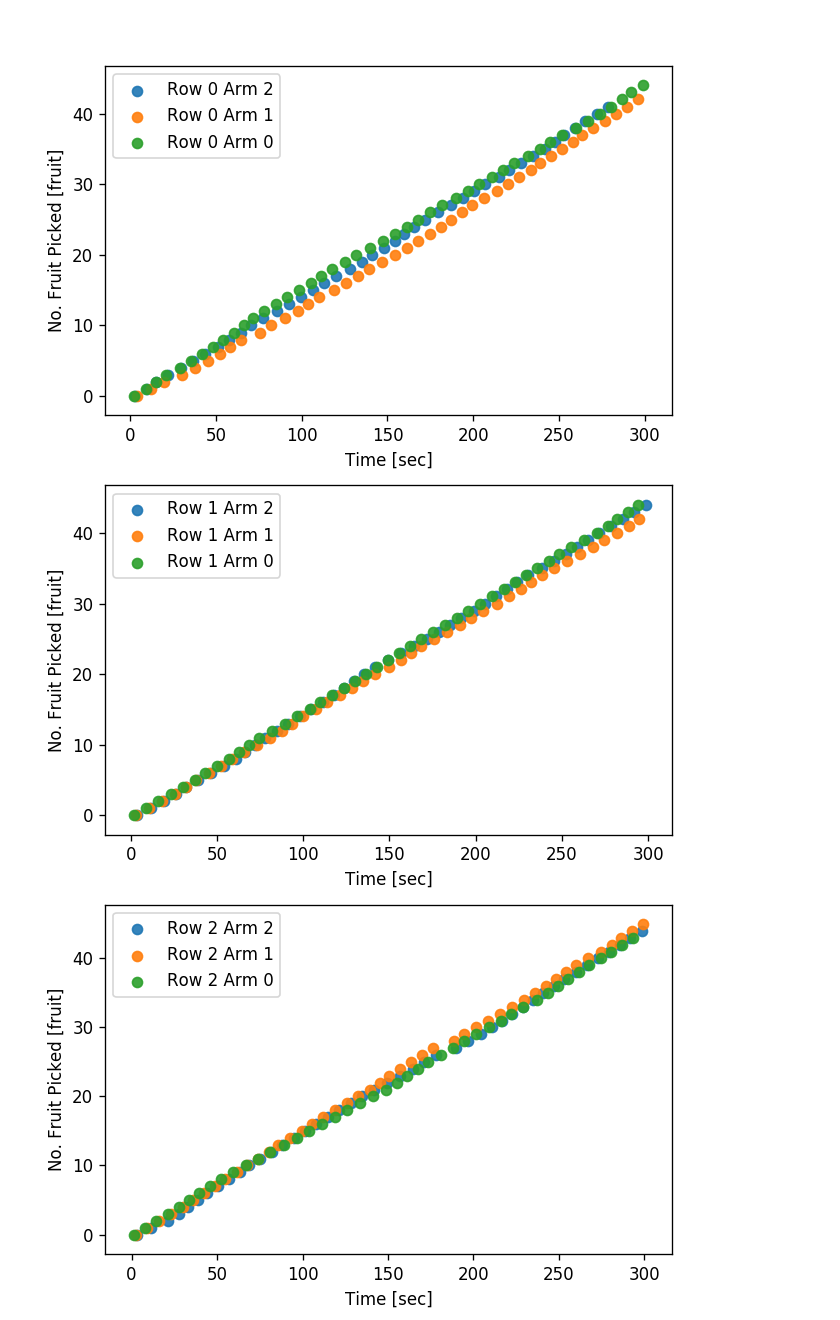

In [483]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(num_row, figsize=(7, 11))

for rows in range(num_row):
    for manipulators in range((num_arms-1), -1, -1):
        time_apples = np.copy(a[rows,manipulators].pickData())
        apples    = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [484]:
# analyze the % time each arm is in each state 
idle = 0.
picking = 0.
retracting = 0.
unloading = 0.

tot_num_arms = num_arms*num_row

state_step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],state_step] = arm_num[1]
        
        if arm_num[1] == 0:
            idle += 1
        elif arm_num[1] == 1:
            picking += 1
        elif arm_num[1] == 2:
            retracting += 1
        elif arm_num[1] == 3:
            unloading += 1
        
    state_step += 1
        
idle_arm = 0.
pick_arm = 0.
retr_arm = 0.
unlo_arm = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot = []
pick_plot = []
retr_plot = []
unlo_plot = []


# for each arm
for i in range(9):
    for x in state_data[i]:
        if x == 0:
            idle_arm += 1
        elif x == 1:
            pick_arm += 1
        elif x == 2:
            retr_arm += 1
        elif x == 3:
            unlo_arm += 1
    
    total = idle_arm + pick_arm + retr_arm + unlo_arm
    
    idle_plot.append(idle_arm)
    pick_plot.append(pick_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    idle_arm = 0.
    pick_arm = 0.
    retr_arm = 0.
    unlo_arm = 0.



In [485]:
## Functions to add grouping into the arm state percentage plot (and other future plots)
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib

def mk_groups(data):
    # function takes a dictionary (or anything with an items() method, like collections.OrderedDict) and converts it to a data format that is then used to create the chart. It is basically a list
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    # creates a vertical line in the subplot at the specified positions (in axes coordinates)
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    # takes a dictionary and creates the subplot with the labels beneath
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)

    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
        
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale, ypos)
        ypos -= .1



<IPython.core.display.Javascript object>


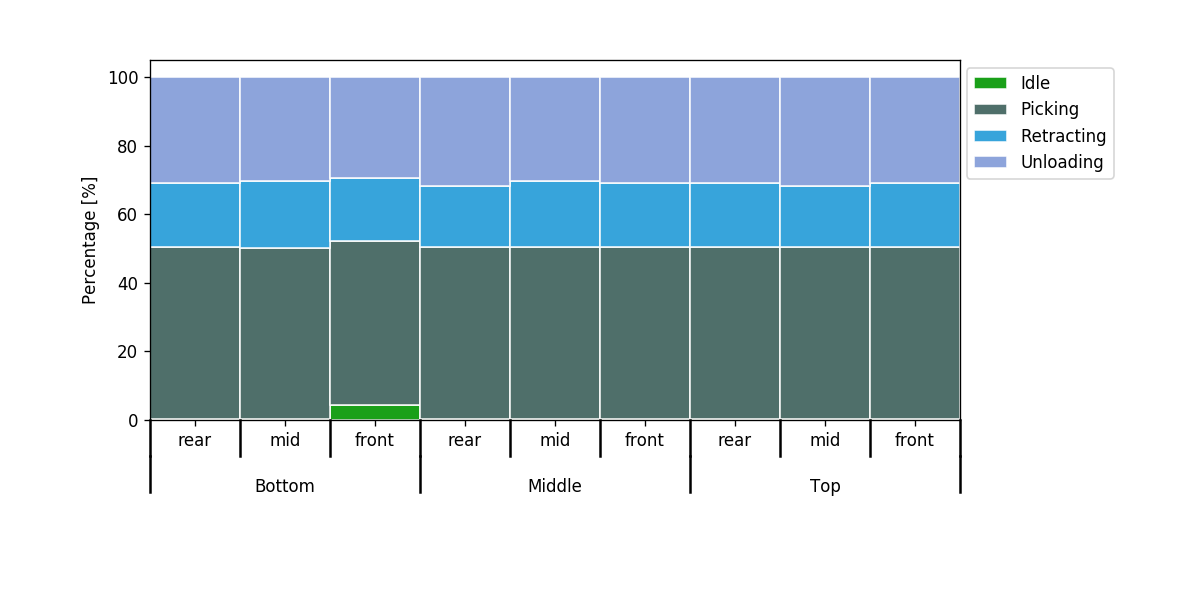

In [486]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

data = {'Bottom':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Middle':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
       }



# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(1,len(idle_plot)+1)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 
# print(tick_pos)

# Create the total steps per state
totals = [i+j+k+l for i,j,k,l in zip(idle_plot, pick_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for picking state
per_pick = [i / j * 100 for  i,j in zip(pick_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#019600',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pick, 
       # with per_idle
       bottom=per_idle, 
       # labeled 
       label='Picking', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3C5F5A', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with per_idle and per_pick on bottom
       bottom=[i+j for i,j in zip(per_idle, per_pick)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#219AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with all other percents on bottom
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pick, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#819AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )


ax.set_ylabel("Percentage [%]")

# grouping x-axis values
label_group_bar(ax, data)
f.subplots_adjust(bottom=0.3, top=0.9, right=0.8)
# f.subplots_adjust()

# rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

In [487]:
# total values 
idle_time_all_arms = idle*dt
picking_time_all_arms = picking*dt
retracting_time_all_arms = retracting*dt
unloading_time_all_arms = unloading*dt

print("total time spent idle for all arms:", idle_time_all_arms, "sec")
print("total time spent picking for all arms:", picking_time_all_arms, "sec")
print("total time spent retracting for all arms:", retracting_time_all_arms, "sec")
print("total time spent unloading for all arms:", unloading_time_all_arms, "sec")

total_time = (idle_time_all_arms + picking_time_all_arms + retracting_time_all_arms + unloading_time_all_arms) # / (num_arms*num_row_arms)

print("total time all arms:", total_time, "sec") 
print("Which totals internal simulator seconds multiplied by number of arms")

percent_idle = (idle_time_all_arms / total_time) * 100
percent_picking = (picking_time_all_arms / total_time) * 100
percent_retracting = (retracting_time_all_arms / total_time) * 100
percent_unloading = (unloading_time_all_arms / total_time) * 100

print("")
print("For all arms:")
print("% time idle:", percent_idle, "% time picking:", percent_picking, "% time retracting:", percent_retracting, "% time unloading:", percent_unloading)

total time spent idle for all arms: 16.87 sec
total time spent picking for all arms: 1348.76 sec
total time spent retracting for all arms: 503.84000000000003 sec
total time spent unloading for all arms: 830.62 sec
total time all arms: 2700.0899999999997 sec
Which totals internal simulator seconds multiplied by number of arms

For all arms:
% time idle: 0.6247939883485366 % time picking: 49.95240899377429 % time retracting: 18.660118736782852 % time unloading: 30.762678281094335


In [488]:
# Calculate how many goals wer given to each arm and how many of those were reached
for rows in range(num_row):
    for count in range(num_arms):
        given = a[rows, count].goals_given
        reached = a[rows, count].reached_goals
        percent_reached = (reached / given) * 100
        
        print("For arm", count, "row", rows)
        print("Number of goals given:", given, "number of goals reached:", reached)
        print("Percent reached goals:", percent_reached, "%")
        print("")

For arm 0 row 0
Number of goals given: 46 number of goals reached: 45
Percent reached goals: 97.82608695652173 %

For arm 1 row 0
Number of goals given: 50 number of goals reached: 43
Percent reached goals: 86.0 %

For arm 2 row 0
Number of goals given: 48 number of goals reached: 42
Percent reached goals: 87.5 %

For arm 0 row 1
Number of goals given: 46 number of goals reached: 45
Percent reached goals: 97.82608695652173 %

For arm 1 row 1
Number of goals given: 46 number of goals reached: 43
Percent reached goals: 93.47826086956522 %

For arm 2 row 1
Number of goals given: 48 number of goals reached: 45
Percent reached goals: 93.75 %

For arm 0 row 2
Number of goals given: 48 number of goals reached: 44
Percent reached goals: 91.66666666666666 %

For arm 1 row 2
Number of goals given: 50 number of goals reached: 46
Percent reached goals: 92.0 %

For arm 2 row 2
Number of goals given: 52 number of goals reached: 45
Percent reached goals: 86.53846153846155 %



num runs 30001


<IPython.core.display.Javascript object>


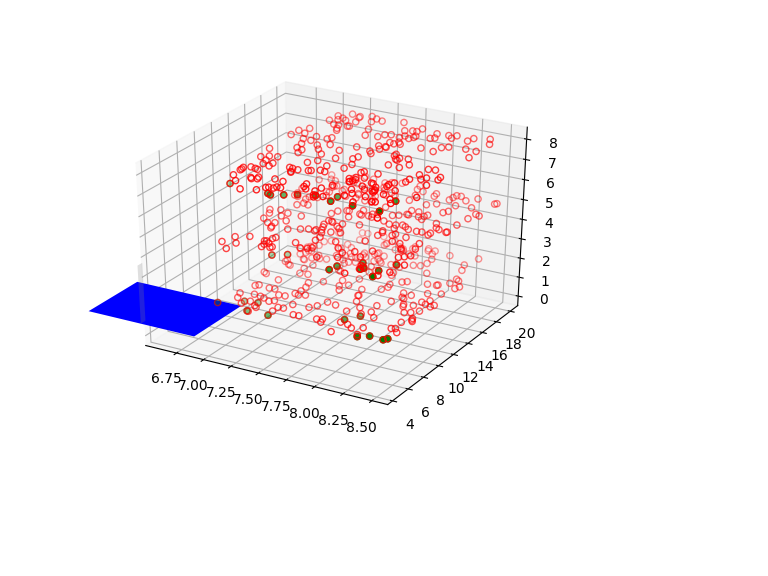

KeyboardInterrupt: 

In [489]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(6, 12)
        ax.set_zlim(-1, 11)
        
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [490]:
# need to print all the fruit that remains unpicked
miss  = 0
sched = 0 
pick  = 0

# prints all the fruit that has not been picked
for x in range(len(fruit.sortedFruit[1])):
    if fruit.sortedFruit[:,x][3] == 0: 
        miss += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 1:
        sched += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 2:
        pick += 1
        

        
print("Total missed fruit:", miss)
print("Total scheduled, but not picked fruit:", sched)
print("Total picked fruit:", pick)

print("")
print("They add up to:", miss+sched+pick)
print("Total unpicked fruit:", miss+sched)

Total missed fruit: 125
Total scheduled, but not picked fruit: 112
Total picked fruit: 363

They add up to: 600
Total unpicked fruit: 237
